# Winery classification with the multivariate Gaussian

In this notebook, we return to winery classification, using the full set of 13 features.

## 1. Load in the data

As usual, we start by loading in the Wine data set. Make sure the file `wine.data.txt` is in the same directory as this notebook.

Recall that there are 178 data points, each with 13 features and a label (1,2,3). As before, we will divide this into a training set of 130 points and a test set of 48 points.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls "/content/drive/MyDrive/Colab Notebooks/UCSanDiegoX DSE220x Machine Learning Fundamentals/Week3/winery-multivariate"
local_folder = "/content/drive/MyDrive/Colab Notebooks/UCSanDiegoX DSE220x Machine Learning Fundamentals/Week3/winery-multivariate/"

_ipynb_checkpoints  wine.names.txt
wine.data.txt	    winery-classification-gaussian.ipynb


In [3]:
# Standard includes
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
# Useful module for dealing with the Gaussian density
from scipy.stats import norm, multivariate_normal

In [4]:
# Load data set.
data = np.loadtxt(f'{local_folder}wine.data.txt', delimiter=',')
# Names of features
featurenames = ['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash','Magnesium', 'Total phenols',
                'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue',
                'OD280/OD315 of diluted wines', 'Proline']
# Split 178 instances into training set (trainx, trainy) of size 130 and test set (testx, testy) of size 48
np.random.seed(0)
perm = np.random.permutation(178)
trainx = data[perm[0:130],1:14]
trainy = data[perm[0:130],0]
testx = data[perm[130:178], 1:14]
testy = data[perm[130:178],0]

## 2. Fit a Gaussian generative model

We now define a function that fits a Gaussian generative model to the data.
For each class (`j=1,2,3`), we have:
* `pi[j]`: the class weight
* `mu[j,:]`: the mean, a 13-dimensional vector
* `sigma[j,:,:]`: the 13x13 covariance matrix

This means that `pi` is a 4x1 array (Python arrays are indexed starting at zero, and we aren't using `j=0`), `mu` is a 4x13 array and `sigma` is a 4x13x13 array.

In [5]:
def fit_generative_model(x,y):
    k = 3  # labels 1,2,...,k
    d = (x.shape)[1]  # number of features
    mu = np.zeros((k+1,d))
    sigma = np.zeros((k+1,d,d))
    pi = np.zeros(k+1)
    for label in range(1,k+1):
        indices = (y == label)
        mu[label] = np.mean(x[indices,:], axis=0)
        sigma[label] = np.cov(x[indices,:], rowvar=0, bias=1)
        pi[label] = float(sum(indices))/float(len(y))
    return mu, sigma, pi

In [6]:
# Fit a Gaussian generative model to the training data
mu, sigma, pi = fit_generative_model(trainx,trainy)

## 3. Use the model to make predictions on the test set

<font color="magenta">**For you to do**</font>: Define a general purpose testing routine that takes as input:
* the arrays `pi`, `mu`, `sigma` defining the generative model, as above
* the test set (points `tx` and labels `ty`)
* a list of features `features` (chosen from 0-12)

It should return the number of mistakes made by the generative model on the test data, *when restricted to the specified features*. For instance, using the just three features 2 (`'Ash'`), 4 (`'Magnesium'`) and 6 (`'Flavanoids'`) results in 7 mistakes (out of 48 test points), so

        `test_model(mu, sigma, pi, [2,4,6], testx, testy)`

should print 7/48.

**Hint:** The way you restrict attention to a subset of features is by choosing the corresponding coordinates of the full 13-dimensional mean and the appropriate submatrix of the full 13x13 covariance matrix.

In [7]:
# Now test the performance of a predictor based on a subset of features
def test_model(mu, sigma, pi, features, tx, ty):
    #print(pi)
    k = 3
    n_features = len(features)
    teste_pt_len = len(ty)
    score = np.zeros((teste_pt_len, k+1))
    for i in range(teste_pt_len):
      for class_wine in range(1, k+1):
          score[i,class_wine] = np.log(pi[class_wine]) \
                  + multivariate_normal.logpdf(tx[i,features],mean= mu[class_wine,features],cov=sigma[class_wine,features,features])

    # print(score[:,1:4])
    predictions = np.argmax(score[:,1:4], axis=1) + 1
    # print(predictions)
    # print(ty)
    errors = np.sum(predictions != ty)
    print(f'{str(errors)}/{str(teste_pt_len)}')

### <font color="magenta">Fast exercises</font>

*Note down the answers to these questions. You will need to enter them as part of this week's assignment.*

Exercise 1. How many errors are made on the test set when using the single feature 'Ash'?

In [ ]:
test_model(mu, sigma, pi, [2], testx, testy)

29/48


Exercise 2. How many errors when using 'Alcohol' and 'Ash'?

In [ ]:
test_model(mu, sigma, pi, [0,2], testx, testy)

12/48


Exercise 3. How many errors when using 'Alcohol', 'Ash', and 'Flavanoids'?

In [ ]:
test_model(mu, sigma, pi, [0,2,6], testx, testy)

4/48


Exercise 4. How many errors when using all 13 features?

In [ ]:
test_model(mu, sigma, pi, range(0,13), testx, testy)

2/48


Exercise 5. In lecture, we got somewhat different answers to these questions. Why do you think that might be?

ASW.: I think the diferent results might be due to the feature used. Some features don't work well on their own because they are no very discriminative bettween the wine classes. Others, are more informative and are strongly correlated with the classes or another features. Additionally, some features might have high variance or outlier values.

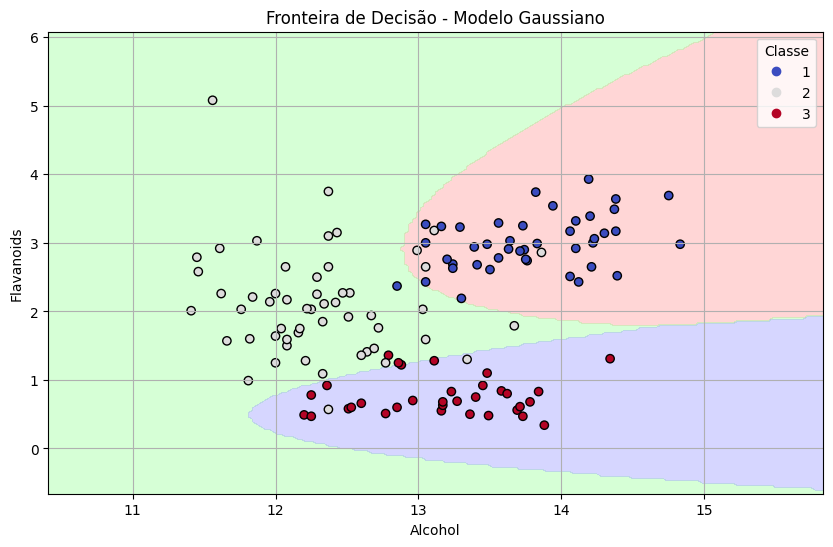

In [8]:
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

def plot_decision_boundary(mu, sigma, pi, features, xdata, ydata):

    x = np.linspace(np.min(xdata[:,features[0]]) - 1, np.max(xdata[:,features[0]]) + 1, 200)
    y = np.linspace(np.min(xdata[:,features[1]]) - 1, np.max(xdata[:,features[1]]) + 1, 200)
    X, Y = np.meshgrid(x, y)
    grid = np.stack([X.ravel(), Y.ravel()], axis=1)

    k = 3
    scores = np.zeros((len(grid), k+1))
    for j in range(1, k+1):
        dist = multivariate_normal(mean=mu[j, features], cov=sigma[j][np.ix_(features, features)])
        scores[:, j] = np.log(pi[j]) + dist.logpdf(grid)

    preds = np.argmax(scores[:,1:], axis=1) + 1
    Z = preds.reshape(X.shape)

    plt.figure(figsize=(10, 6))
    plt.contourf(X, Y, Z, alpha=0.4, levels=[0.5, 1.5, 2.5, 3.5], colors=["#ff9999", "#99ff99", "#9999ff"])
    scatter = plt.scatter(xdata[:, features[0]], xdata[:, features[1]], c=ydata, cmap='coolwarm', edgecolors='k')
    plt.xlabel(featurenames[features[0]])
    plt.ylabel(featurenames[features[1]])
    plt.title("Fronteira de Decisão - Modelo Gaussiano")
    plt.legend(*scatter.legend_elements(), title="Classe")
    plt.grid(True)
    plt.show()

plot_decision_boundary(mu, sigma, pi, [0, 6], trainx, trainy)
